# Examples in bayesian updating for sales

In which we provide an example of how we could use bayesian inference to predict the probability of a deal getting closed.

Point here is to show our estimates of the win probability over time and that it shows a *distribution* of probabilities.

In [1]:
# First, we'll simulate some data
import numpy as np
import pandas as pd

np.random.seed(42)

ids = np.arange(0,100)
wins = np.random.binomial(1, 0.7, size=100)
data = pd.DataFrame({"Opportunity_ID":ids, "Deal_Won":wins})
data

,Opportunity_ID,Deal_Won
0,0,1
1,1,0
2,2,0
3,3,1
4,4,1
...,...,...
95,95,1
96,96,1
97,97,1
98,98,1


In [2]:
import matplotlib.pyplot as plt
# first, plot the prior
from scipy.stats import binom

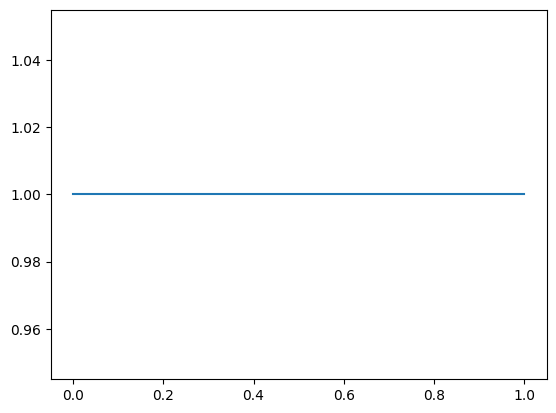

In [3]:

# Define grid
p_grid = np.linspace(start=0, stop=1, num=20)

# Define prior
prior = np.repeat(1, 20)

plt.plot(p_grid, prior)

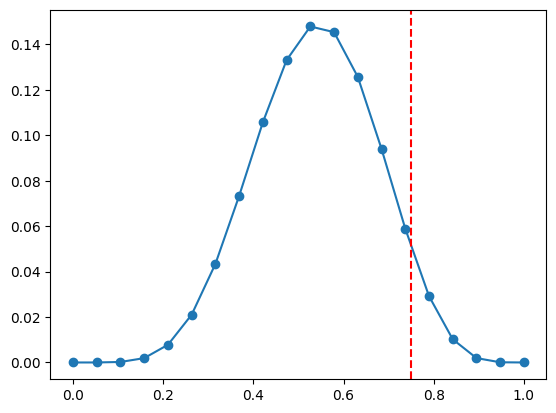

In [4]:
# Define prior
prior = np.repeat(1, 20)

prior = binom.pmf(0,1, p_grid)

# Compute likelihood at each value in grid
likelihood = binom.pmf(6, 10, p_grid)

# Compute product of likelihood and prior
unstd_posterior = likelihood * prior

# Standardize the posterior, so it sums to 1
posterior = unstd_posterior / np.sum(unstd_posterior)

plt.plot(p_grid, posterior, "-o")
plt.axvline(x=0.75, linestyle='--', color='r')

In [5]:
def plot_posterior(prior, W, D, n=20):
    p_grid = np.linspace(start=0, stop=1, num=n)
    # Compute likelihood at each value in grid
    likelihood = binom.pmf(W, D, p_grid)

    # Compute product of likelihood and prior
    unstd_posterior = likelihood * prior

    # Standardize the posterior, so it sums to 1
    posterior = unstd_posterior / np.sum(unstd_posterior)
    # f = plt.plot(p_grid, posterior, "-o")
    return posterior

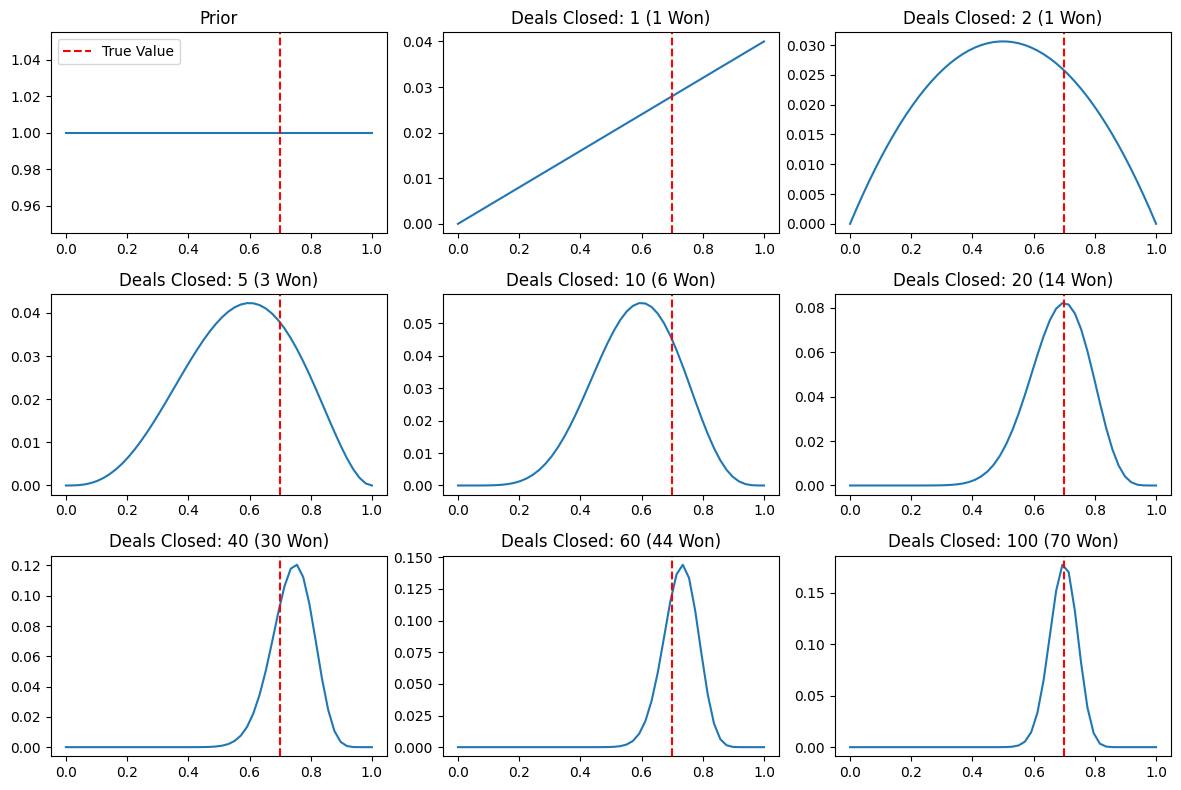

In [6]:
n = 50
# Define prior
prior = np.repeat(1, n)
p_grid = np.linspace(start=0, stop=1, num=n)
# prior = binom.pmf(5,10, p_grid)
# get deal win rate

fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(12,8))

axs = axs.ravel()

for num_draws, ax in zip([0, 1, 2, 5, 10, 20, 40, 60, 100], axs):
    if num_draws == 0:
        ax.plot(p_grid, prior)
        ax.axvline(x=0.7, linestyle='--', color='r', label="True Value")
        ax.set_title("Prior")
        ax.legend()
    else:
        num_wins = np.sum(wins[:num_draws])
        posterior = plot_posterior(prior, num_wins, num_draws, n)
        ax.plot(p_grid, posterior)
        ax.set_title(f"Deals Closed: {num_draws} ({num_wins} Won)")
        ax.axvline(x=0.7, linestyle='--', color='r', label='True Value')

# plot_posterior(prior, 6,9)
plt.tight_layout()
plt.show()

# Bayesian Bazooka

Because many of our problems can't be solved analytically, let's demonstrate this trivial example using MCMC and numpyro.

In [7]:
# Modeling
import numpyro
import numpyro.distributions as dist
from jax import random
import jax.numpy as jnp
from numpyro.infer import MCMC, NUTS, Predictive

# Diagnostics and Viz
# import arviz as az
# from numpyro.diagnostics import hpdi

In [72]:
# 1. Spec Model
def binomial_model(wins=None):
    theta = numpyro.sample('theta', dist.Uniform(low=0, high=1))
    with numpyro.plate('N', len(wins)):
        p = numpyro.sample('p', dist.Bernoulli(theta), obs=wins)
    

# 2. Run Inference engine to get posterior 
# Specify the No U-Turn Sampler (NUTS) for our model in step 1
def infer_model(model, seed=42, **kwargs):
    mcmc = MCMC(sampler=NUTS(model), 
                num_warmup=2000, 
                num_samples=2000) 
    # JAX needs an explicit pseudo-random number generator key
    rng_key = random.PRNGKey(seed = 42)
    mcmc.run(rng_key, **kwargs)
    return mcmc

mcmc = infer_model(binomial_model, seed=42, wins=data['Deal_Won'].to_numpy())
mcmc.print_summary()

sample: 100%|██████████| 4000/4000 [00:01<00:00, 3098.63it/s, 3 steps of size 1.28e+00. acc. prob=0.87]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     theta      0.70      0.05      0.70      0.62      0.77    748.12      1.00

Number of divergences: 0


In [76]:
# Prior Predictive Samples
prior_predictive = Predictive(binomial_model, num_samples=100)
prior_pred_samples = prior_predictive(random.PRNGKey(99), wins=wins)

# Posterior Samples - unknown parameters
posterior_samples = mcmc.get_samples()

# Posterior Predictive Samples - make predictions
posterior_pred = Predictive(binomial_model, posterior_samples=posterior_samples)
posterior_pred_samples = posterior_pred(random.PRNGKey(99), wins=wins)

(array([ 14.,  35., 102., 236., 410., 539., 389., 204.,  58.,  13.]),
 array([0.54167944, 0.57088596, 0.60009247, 0.62929893, 0.65850544,
        0.68771195, 0.71691847, 0.74612498, 0.77533144, 0.80453795,
        0.83374447]),
 <BarContainer object of 10 artists>)

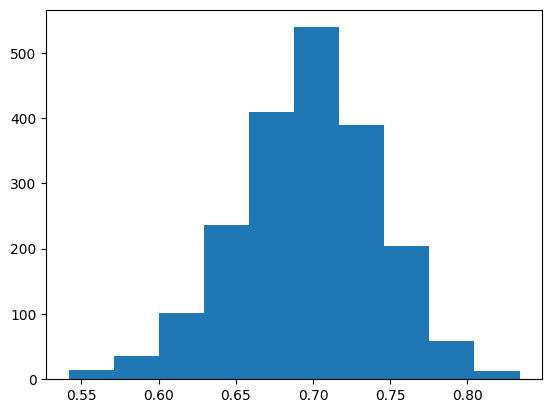

In [77]:
plt.hist(posterior_samples['theta'])